## Random Cut Forest - NYC Taxi Dataset (NAB)
Prima di utilizzare questo script, bisogna caricare il file csv dei dati [nyc_taxi.csv](https://drive.google.com/file/d/1I7Q0BttBM9sgZ3Ekm6cq6u2fCgcp45ef/view?usp=sharing).
Siccome l'algoritmo di [Robust Random Cut Forest](https://github.com/kLabUM/rrcf) non è presente su Colab, bisogna installarlo.

### Anomalie
Le anomalie in questo dataset sono capitate i giorni:
* Maratona di New York - 02/11/2014
* Thanksgiving - 27/11/2014
* Natale
* Capodanno
* Tempesta di neve (13 - 26 Novembre 2014)

In [5]:
!pip install rrcf

In [6]:
# Import delle librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rrcf

In [7]:
# Costanti
DATASET_PATH = 'nyc_taxi.csv'

In [8]:
# Caricamento dataset
taxi = pd.read_csv(DATASET_PATH, index_col=0)
taxi.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [9]:
# Preparazione dati
taxi.index = pd.to_datetime(taxi.index)
dataset = taxi['value'].astype(float).values
dataset

array([10844.,  8127.,  6210., ..., 27309., 26591., 26288.])

In [19]:
# Set parametri albero
num_trees = 200
#shingle_size = 24 # Stream di dati di 12 ore
shingle_size = 48 # Stream di dati di 1 giorno
#shingle_size = 48 * 7 # Stream di dati di 7 giorni
tree_size = 1000

In [20]:
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(dataset, size=shingle_size)
points = np.vstack([point for point in points])
n = points.shape[0]
sample_size_range = (n // tree_size, tree_size)

In [21]:
# Creazione random forest
forest = []
while len(forest) < num_trees:
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    trees = [rrcf.RCTree(points[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

In [22]:
# Setup valori codisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)

In [23]:
# Merge alberi decisione
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                        for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)

In [24]:
# Calcolo media codisp
avg_codisp /= index
avg_codisp.index = taxi.iloc[(shingle_size - 1):].index

In [25]:
# Creazione eventi anomali
events = {
'independence_day' : ('2014-07-04 00:00:00',
                      '2014-07-07 00:00:00'),
'labor_day'        : ('2014-09-01 00:00:00',
                      '2014-09-02 00:00:00'),
'labor_day_parade' : ('2014-09-06 00:00:00',
                      '2014-09-07 00:00:00'),
'nyc_marathon'     : ('2014-11-02 00:00:00',
                      '2014-11-03 00:00:00'),
'thanksgiving'     : ('2014-11-27 00:00:00',
                      '2014-11-28 00:00:00'),
'christmas'        : ('2014-12-25 00:00:00',
                      '2014-12-26 00:00:00'),
'new_year'         : ('2015-01-01 00:00:00',
                      '2015-01-02 00:00:00'),
'blizzard'         : ('2015-01-26 00:00:00',
                      '2015-01-28 00:00:00')
}
taxi['event'] = np.zeros(len(taxi))
for event, duration in events.items():
    start, end = duration
    taxi.loc[start:end, 'event'] = 1

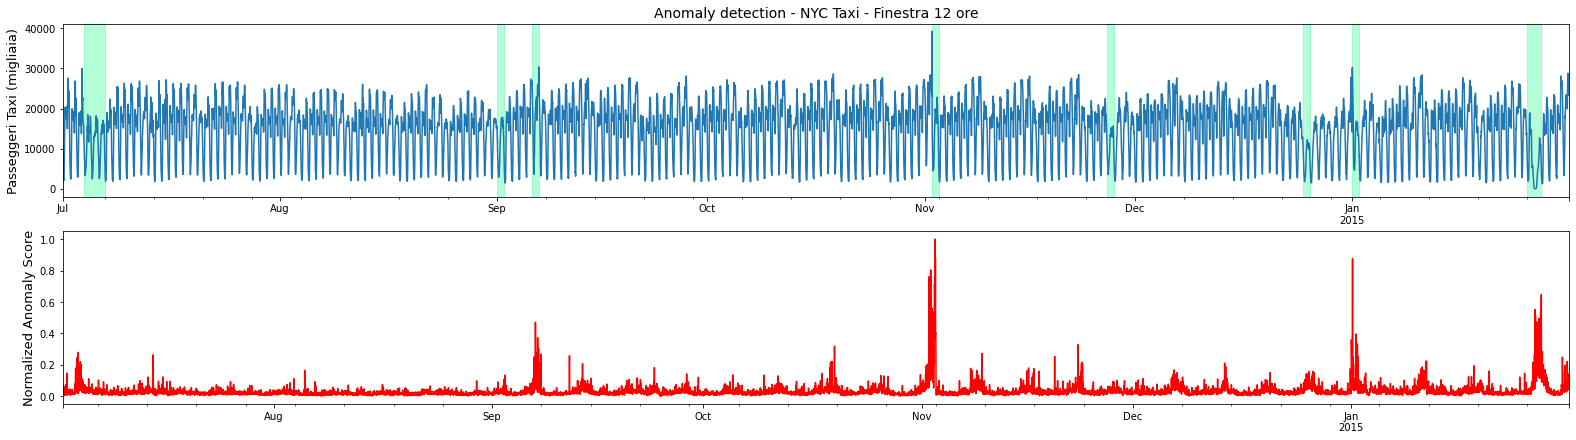

In [27]:
# Plot dei risultati

# Normalizzazione punteggi (valori tra 0 e 1)
avg_codisp = ((avg_codisp - avg_codisp.min())
              / (avg_codisp.max() - avg_codisp.min()))

fig, ax = plt.subplots(2, figsize=(27, 7))
(taxi['value']).plot(ax=ax[0])
avg_codisp.plot(ax=ax[1], color='red')

for event, duration in events.items():
    start, end = duration
    ax[0].axvspan(start, end, alpha=0.3,
                  color='springgreen')

ax[0].set_xlabel('')
ax[1].set_xlabel('')

ax[0].set_ylabel('Passeggeri Taxi (migliaia)', size=13)
ax[1].set_ylabel('Normalized Anomaly Score', size=13)
ax[0].set_title('Anomaly detection - NYC Taxi - Finestra 12 ore',
                size=14)

fig.savefig('RCF_NTC_12H.png')
plt.show()

In [34]:
avg_codisp.sort_values(ascending=False)
first8 = avg_codisp.sort_values(ascending=False)[0:8]
first8

timestamp
2014-11-02 22:00:00    1.000000
2014-11-02 23:00:00    0.878366
2015-01-01 05:00:00    0.875524
2014-11-02 07:00:00    0.803756
2014-11-02 01:30:00    0.760521
2014-11-02 20:00:00    0.715194
2014-11-02 02:00:00    0.708778
2015-01-28 00:30:00    0.646572
dtype: float64

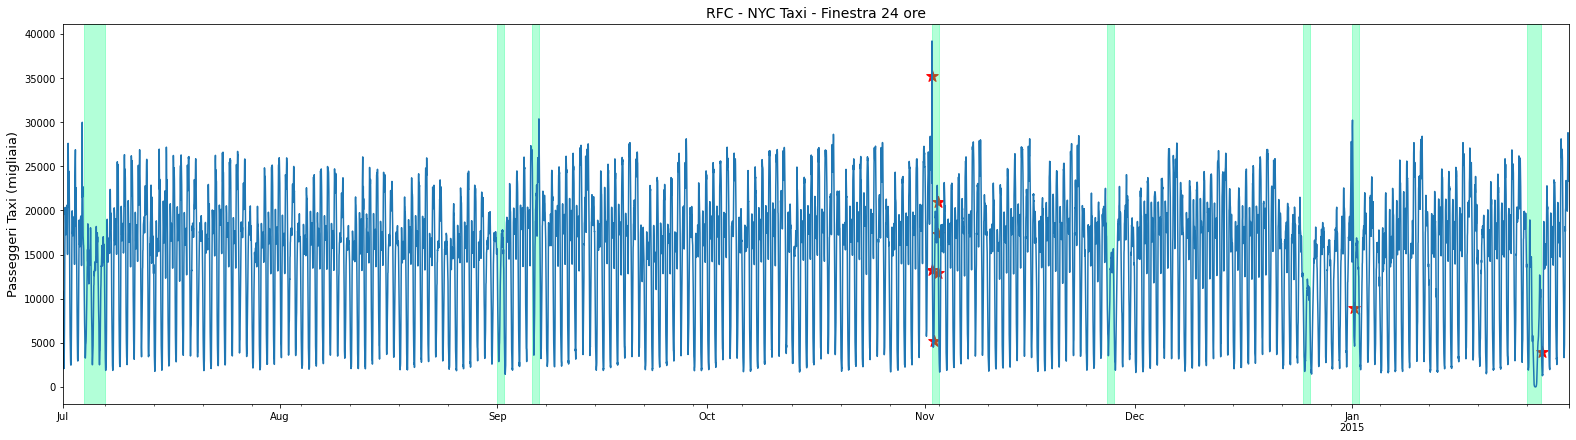

In [54]:
fig, ax = plt.subplots(1, figsize=(27, 7))
(taxi['value']).plot(ax=ax)
#avg_codisp.plot(ax=ax, color='red')
ax.scatter(first8.index, taxi['value'][first8.index], color='red', marker='*', s=150)

for event, duration in events.items():
    start, end = duration
    ax.axvspan(start, end, alpha=0.3,
                  color='springgreen')

ax.set_xlabel('')

ax.set_ylabel('Passeggeri Taxi (migliaia)', size=13)
ax.set_title('RFC - NYC Taxi - Finestra 24 ore',size=14)

fig.savefig('RCF_NTC_24H.png')
plt.show()